In [14]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn import metrics
import seaborn as sns

In [2]:
questions_data = pd.read_csv("questions_nb_predictions.csv")

In [3]:
questions_data.head(2)

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Id,OwnerUserId,CreationDate,Score,Title,Body,highest_answer_score,num_answers,has_positive_answer,Full_Text,Title_Word_Count,Body_Word_Count,SPLIT,NB_prediction
0,0,0,0,0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,12,4,1,How can I find the full path to a font from it...,17,70,TRAIN,0.400395
1,1,1,1,1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,9,2,1,Get a preview JPEG of a PDF on Windows? <p>I h...,9,38,TRAIN,0.287295


In [4]:
from random import randint

In [5]:
questions_data['SPLIT'].value_counts()

TRAIN    441617
TEST     165665
Name: SPLIT, dtype: int64

In [6]:
train_split = questions_data.loc[questions_data['SPLIT'] == 'TRAIN']
test_split = questions_data.loc[questions_data['SPLIT'] == 'TEST']

In [7]:
X_train = train_split['Title']
X_test = test_split['Title']

y_train = train_split['has_positive_answer']
y_test = test_split['has_positive_answer']

In [11]:
results = {}

for i in range(1,7):
    
    results[i] = {}
    
    variable_ngram_range = (1, i) # max size at i
    
    vect = CountVectorizer(stop_words = 'english', ngram_range=variable_ngram_range)
    x_train_cv = vect.fit_transform(X_train)
    x_test_cv = vect.transform(X_test)
    
    clf = MultinomialNB()
    clf.fit(x_train_cv, y_train)
    
    # do on test data
    y_pred_raw = clf.predict_proba(x_test_cv)
    y_pred_raw = [x[1] for x in y_pred_raw]
    y_pred = (np.array(y_pred_raw) > 0.5).astype(int)
    
    test_auc = metrics.roc_auc_score(y_test, y_pred_raw)
    
    results[i]['test_auc'] = test_auc
    
    # do the same on the training data
    y_pred_raw = clf.predict_proba(x_train_cv)
    y_pred_raw = [x[1] for x in y_pred_raw]
    y_pred = (np.array(y_pred_raw) > 0.5).astype(int)
    
    train_auc = metrics.roc_auc_score(y_train, y_pred_raw)
    
    results[i]['train_auc'] = train_auc
    
    print(results)

{1: {'test_auc': 0.6493861250703213, 'train_auc': 0.7018864540254128}}
{1: {'test_auc': 0.6493861250703213, 'train_auc': 0.7018864540254128}, 2: {'test_auc': 0.6403950642023739, 'train_auc': 0.883362295887359}}
{1: {'test_auc': 0.6493861250703213, 'train_auc': 0.7018864540254128}, 2: {'test_auc': 0.6403950642023739, 'train_auc': 0.883362295887359}, 3: {'test_auc': 0.6326670667465149, 'train_auc': 0.9634717193947979}}
{1: {'test_auc': 0.6493861250703213, 'train_auc': 0.7018864540254128}, 2: {'test_auc': 0.6403950642023739, 'train_auc': 0.883362295887359}, 3: {'test_auc': 0.6326670667465149, 'train_auc': 0.9634717193947979}, 4: {'test_auc': 0.6289044655999619, 'train_auc': 0.9840511711684685}}
{1: {'test_auc': 0.6493861250703213, 'train_auc': 0.7018864540254128}, 2: {'test_auc': 0.6403950642023739, 'train_auc': 0.883362295887359}, 3: {'test_auc': 0.6326670667465149, 'train_auc': 0.9634717193947979}, 4: {'test_auc': 0.6289044655999619, 'train_auc': 0.9840511711684685}, 5: {'test_auc': 0.6

In [23]:
results_list = []

for max_ngram_size in results:
    ngram_results = results[max_ngram_size]
    
    results_list.append({
        "Max N-Gram Size": max_ngram_size,
        "Train AUC": ngram_results['train_auc'],
        "Test AUC": ngram_results['test_auc']
    })
    
results_df = pd.DataFrame(results_list)

<AxesSubplot:xlabel='Max N-Gram Size', ylabel='value'>

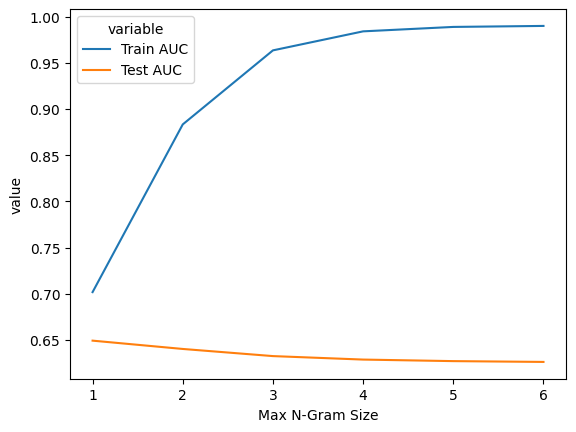

In [32]:
sns.lineplot(x='Max N-Gram Size', y='value', hue='variable', 
             data=pd.melt(results_df, ['Max N-Gram Size']))

,Max N-Gram Size,Train AUC,Test AUC
0,1,0.701886,0.649386
1,2,0.883362,0.640395
2,3,0.963472,0.632667
3,4,0.984051,0.628904
4,5,0.988842,0.627229
5,6,0.989924,0.626364
